In [2]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score

Read the data file.

In [3]:
data = pd.read_pickle('df_LA_parcels_LAcity_cleaned_REV2_MB.pkl', compression = "gzip")

In [4]:
data.head()

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,TaxRateArea,Cluster,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,16,2143,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2..."
1,2261032003,1696.0,3,2,447434.0,2013,741740.0,1959,1959,0100,16,2177,91436,1514,2971.162781,29494.940324,Encino,6754.044922,344.477163,"POLYGON ((-118.47423 34.16359, -118.47423 34.1..."
3,5109011014,1613.0,3,1,187966.0,2009,237927.0,1907,1909,0100,7,12116,90011,3420,2043.041637,7194.083587,South Park,6750.490234,370.022185,"POLYGON ((-118.27134 34.00302, -118.27151 34.0..."
4,5561004003,2163.0,2,2,74716.0,1975,175208.0,1960,1961,0100,67,9161,90069,1123,6799.550634,16358.346982,Hollywood Hills West,7120.636719,349.173429,"POLYGON ((-118.38809 34.10057, -118.38811 34.1..."
5,5561024005,2494.0,2,2,4600000.0,2021,5700000.0,1965,1966,0101,67,9161,90069,1236,6382.749033,14270.864947,Hollywood Hills West,11411.411133,451.598959,"POLYGON ((-118.38526 34.09769, -118.38563 34.0..."


Keep a list of column names handy.

In [5]:
num_var = list(data.columns)

Check out the correlation between each of the current features of the data set.

In [6]:
correlation = data.corr()

In [7]:
correlation

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,Cluster,ZIPcode5,BusBenchClosestDist,SubwayStopClosestDist,ShapeSTAre,ShapeSTLen
AIN,1.000000,-0.103942,-0.195446,-0.166530,0.052267,-0.040810,0.025399,-0.382969,-0.327086,0.007208,0.830936,-0.824458,-0.018208,-0.614728,-0.147684,-0.182567
SQFTmain,-0.103942,1.000000,0.646431,0.848066,0.560562,0.073923,0.668026,0.412913,0.502264,-0.049639,-0.092489,0.024038,0.297097,0.082434,0.446122,0.488667
Bedrooms,-0.195446,0.646431,1.000000,0.683265,0.257328,0.054724,0.324366,0.369529,0.462992,-0.027450,-0.161353,0.169325,0.157685,0.239274,0.240296,0.283447
Bathrooms,-0.166530,0.848066,0.683265,1.000000,0.469387,0.112029,0.561753,0.499703,0.621235,-0.054021,-0.151002,0.096523,0.282810,0.141820,0.349102,0.397049
LandValue,0.052267,0.560562,0.257328,0.469387,1.000000,0.352224,0.966232,0.160879,0.240911,-0.035154,0.052950,-0.144158,0.196667,-0.106685,0.316095,0.310402
LandBaseYear,-0.040810,0.073923,0.054724,0.112029,0.352224,1.000000,0.330670,0.095305,0.161873,0.010494,-0.038158,0.034094,0.018509,0.022041,0.008791,0.005694
TotalValue,0.025399,0.668026,0.324366,0.561753,0.966232,0.330670,1.000000,0.231007,0.315397,-0.038071,0.029130,-0.118682,0.222401,-0.082731,0.353695,0.350070
YearBuilt,-0.382969,0.412913,0.369529,0.499703,0.160879,0.095305,0.231007,1.000000,0.854607,-0.028769,-0.342816,0.411215,0.243588,0.448370,0.183344,0.213166
EffectiveYearBuilt,-0.327086,0.502264,0.462992,0.621235,0.240911,0.161873,0.315397,0.854607,1.000000,-0.034975,-0.287390,0.333307,0.229698,0.347583,0.187714,0.221570
TaxRateArea,0.007208,-0.049639,-0.027450,-0.054021,-0.035154,0.010494,-0.038071,-0.028769,-0.034975,1.000000,0.039134,0.024699,-0.040831,0.050334,-0.027189,-0.030655


Look at the info of each column in the data set.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439943 entries, 0 to 632869
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   AIN                    439943 non-null  int64   
 1   SQFTmain               439943 non-null  float64 
 2   Bedrooms               439943 non-null  int64   
 3   Bathrooms              439943 non-null  int64   
 4   LandValue              439943 non-null  float64 
 5   LandBaseYear           439943 non-null  int64   
 6   TotalValue             439943 non-null  float64 
 7   YearBuilt              439943 non-null  int64   
 8   EffectiveYearBuilt     439943 non-null  int64   
 9   PropertyUseCode        439943 non-null  object  
 10  TaxRateArea            439943 non-null  int64   
 11  Cluster                439943 non-null  int64   
 12  ZIPcode5               439943 non-null  int64   
 13  ZIPcode4               437782 non-null  object  
 14  BusBenchClosestDist 

In [9]:
data.isnull().sum()

AIN                         0
SQFTmain                    0
Bedrooms                    0
Bathrooms                   0
LandValue                   0
LandBaseYear                0
TotalValue                  0
YearBuilt                   0
EffectiveYearBuilt          0
PropertyUseCode             0
TaxRateArea                 0
Cluster                     0
ZIPcode5                    0
ZIPcode4                 2161
BusBenchClosestDist         0
SubwayStopClosestDist       0
Neighborhood                0
ShapeSTAre                  0
ShapeSTLen                  0
geometry                    0
dtype: int64

Split the data into training set, validation set, and test set.

In [10]:
train, remainder = train_test_split(data, test_size = 0.3, random_state = 0)
val, test = train_test_split(remainder, test_size = 0.5, random_state = 0)

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.99997726978268%
Val 14.999897714022042%
Test 15.000125016195279%


## Start with Feature Engineering

Keep a list of thoughts of each feature and what to do with each feature <br>

Feature: <br>

AIN: No application. <br>

SQFTmain: Directly into Linear Regression Model. <br>

Bedrooms: Directly into Linear Regression Model. <br>

Bathrooms: Directly into Linear Regression Model. <br>

LandValue: Does not make sense to include in model, this would be part of the answer. Data leakage <br>

LandBaseYear: Defines how recently a piece of land was sold. Directly into model. <br>

TotalValue: This is the target. <br>

YearBuilt: Either this or the one below goes into the model. Effective year built also includes renovations and improvements but those could be subjective measures. <br>

EffectiveYearBuilt: Directly into Linear Regression Model. <br>

PropertyUseCode: Can one-hot-encode to measure changes in home value due to pool/no pool. <br>

TaxRateArea: Bad correlation with total value, so probably not useful in the ML model. <br>

Cluster: Bad correlation with total value, so probably not useful in the ML model. <br>

Zipcode5: No apparent correlation with TotalValue, might not be useful to predicting home prices. <br>

Zipcode4: Similar to zipcode5, but even worse because there are null values present. <br>

BusBenchClosestDist: Directly into Linear Regression Model. <br>

SubwayStopClosestDist: May not be the best indicator of home prices because subways can be quite loud to live near, so the convenience vs. noise may conflict with each other. Also must consider the quality of the subways in California, this would probably be a more useful feature in New York. <br>

Neighborhood: After graphing vs. TotalValue, it seems that all rich neighborhoods have cheap homes in them as well. This can be a good feature to detect strictly poor neighborhoods to add as a feature in the model, but might not be useful for rich neighborhoods due to high variance of home prices. <br>

ShapeSTAre: Directly into Linear Regression Model. <br>

ShapeSTLen: It seems redundant to include with ShapeSTAre. Try including it and see if the model improves. <br>

geometry: Maybe there could be a correlation to find what shapes of lots are more attractive. <br>

<br>
One hot encode the property use code to distinguish between homes with pools, without pools, etc.

In [11]:
def ohe_pusecode(data):
    """
    One-hot-encodes Property Use Code.
    New columns are of the form PropertyUseCode_CODE
    """
    # List categories
    categories = ['0100', # No Pool
                  '0101', # Pool
                  '0103', # Pool and misc.
                  '0104', # Therapy Pool
                  ]

    category_type = pd.CategoricalDtype(categories=categories)
    data['PropertyUseCode'] = data['PropertyUseCode'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='PropertyUseCode',
                          columns=['PropertyUseCode'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_pusecode(train)

In [12]:
training_data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104
549190,6075031037,2102.0,4,3,163994.0,2004,291407.0,1991,1999,465,...,1574,1328.401572,2438.546134,Vermont Vista,4582.611328,330.491766,"POLYGON ((-118.28088 33.93555, -118.28086 33.9...",0,0,0
71546,2217011066,1468.0,3,2,520800.0,2021,651000.0,1930,1955,13,...,4045,2278.987082,22582.971949,Van Nuys,9719.463867,413.992977,"POLYGON ((-118.44382 34.19576, -118.44382 34.1...",0,0,0
378098,5023024024,754.0,2,1,39419.0,1982,76860.0,1922,1923,68,...,4007,678.685043,4624.928835,Leimert Park,5195.177734,339.760657,"POLYGON ((-118.32046 34.01018, -118.32089 34.0...",0,0,0
102429,2305018007,1269.0,3,2,212739.0,2003,354561.0,1955,1955,13,...,2127,2102.351378,18939.640434,Sun Valley,5951.470703,313.539365,"POLYGON ((-118.40909 34.21286, -118.40927 34.2...",0,0,0
463833,5510018031,2039.0,3,3,146570.0,1981,254724.0,1928,1929,67,...,4736,559.808250,14914.832433,Beverly Grove,6199.919922,347.997417,"POLYGON ((-118.36231 34.06660, -118.36236 34.0...",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176284,2556012005,1344.0,3,2,157438.0,2001,320162.0,1992,1992,13,...,2517,1939.235008,41445.876985,Sunland,4194.666992,339.677067,"POLYGON ((-118.30318 34.26463, -118.30318 34.2...",0,0,0
630487,7559033009,1236.0,2,2,569317.0,2018,711646.0,1955,1955,14,...,3422,1308.163573,38311.533601,San Pedro,6467.133789,335.582498,"POLYGON ((-118.31392 33.73820, -118.31411 33.7...",1,0,0
121887,2377019004,4785.0,5,5,535151.0,1999,1375902.0,1998,1998,13,...,4165,2937.659542,8241.044191,Studio City,11202.065430,460.089356,"POLYGON ((-118.38863 34.13299, -118.38840 34.1...",0,0,0
622799,7469016003,1700.0,3,2,105655.0,1979,196660.0,1960,1960,21,...,6114,2284.787464,38028.566926,San Pedro,6835.746094,373.404110,"POLYGON ((-118.30099 33.71558, -118.30105 33.7...",0,0,0


Plot Neighborhood vs. TotalValue to see the trend. Every neighborhood seems to have less expensive homes, but not all neighborhoods have extremely expensive homes.

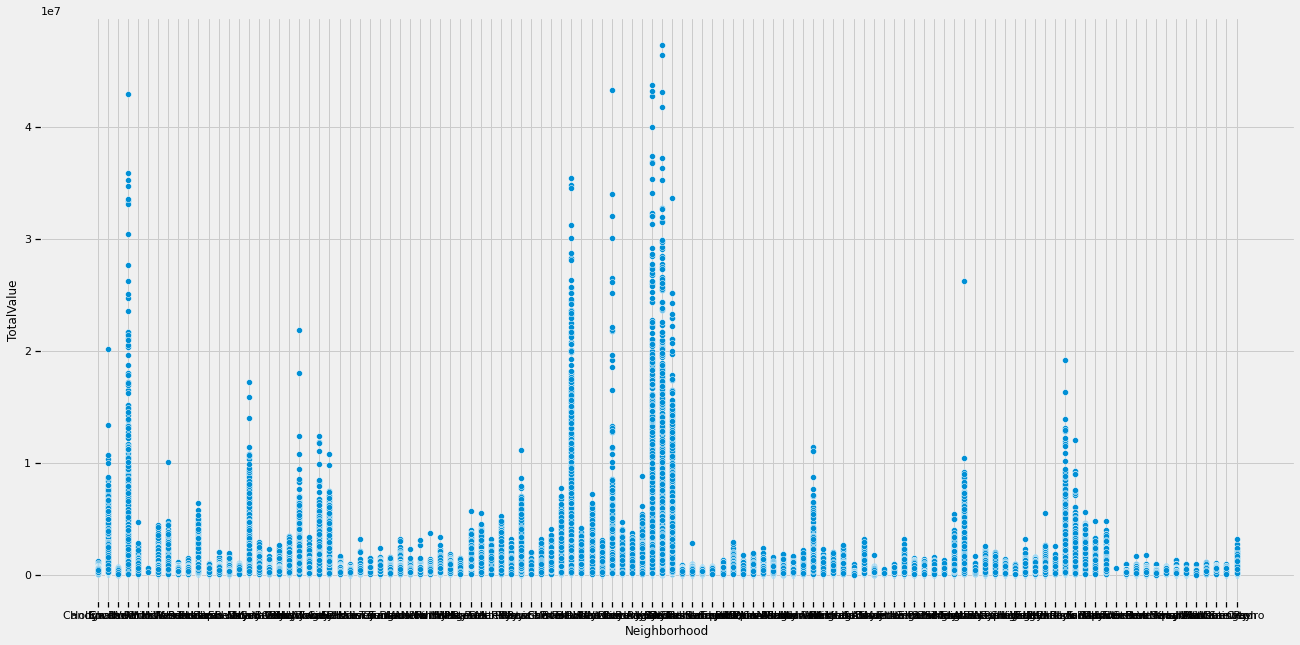

In [13]:
plt.figure(figsize = (20, 10))
ax = sns.scatterplot(x = 'Neighborhood', y = 'TotalValue', data = data)

In [14]:
# Find relevant median values (by neighborhood) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'LandBaseYear', 'SQFTmain', 'TotalValue']]
    .groupby('Neighborhood').median()
)
neighborhood_medians

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
Neighborhood,,,,,
Adams-Normandie,1907.0,1911.0,2002.0,1760.0,266330.0
Arleta,1953.0,1954.0,2002.0,1320.0,298117.0
Arlington Heights,1914.0,1919.0,2002.0,2100.0,408003.0
Atwater Village,1926.0,1934.0,2001.0,1250.0,381821.5
Baldwin Hills/Crenshaw,1950.0,1954.0,1998.0,1754.0,383644.0
...,...,...,...,...,...
Westwood,1937.0,1948.0,2001.0,2807.5,1504328.5
Wilmington,1951.0,1955.0,2000.0,1228.0,262225.5
Windsor Square,1921.0,1930.0,2003.0,3078.5,1369535.0


In [15]:
neighborhood_medians.corr()

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
YearBuilt,1.000000,0.981086,-0.019032,0.363398,0.309701
EffectiveYearBuilt,0.981086,1.000000,-0.016513,0.413218,0.407453
LandBaseYear,-0.019032,-0.016513,1.000000,-0.206076,0.087615
SQFTmain,0.363398,0.413218,-0.206076,1.000000,0.826612
TotalValue,0.309701,0.407453,0.087615,0.826612,1.000000


Since Real Estate prices are very dependent on its neighbors, these median values can be a useful representation of the overall condition of the neighborhood. Add median year built, effective year built, and sqft main to the data set. LandBaseYear seems to have low correlation so we will remove that, and total value would be data leakage.

In [16]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(training_data)

In [17]:
training_data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median
0,6075031037,2102.0,4,3,163994.0,2004,291407.0,1991,1999,465,...,Vermont Vista,4582.611328,330.491766,"POLYGON ((-118.28088 33.93555, -118.28086 33.9...",0,0,0,1928.0,1938.0,1158.5
1,6088016025,1600.0,3,1,183743.0,2001,229671.0,1917,1925,7,...,Vermont Vista,8109.527344,364.470337,"POLYGON ((-118.28436 33.92625, -118.28453 33.9...",0,0,0,1928.0,1938.0,1158.5
2,6038006043,777.0,2,1,350263.0,2005,437822.0,1947,1947,212,...,Vermont Vista,5406.794922,350.320482,"POLYGON ((-118.28418 33.95691, -118.28426 33.9...",0,0,0,1928.0,1938.0,1158.5
3,6038014048,1458.0,4,2,383370.0,2019,479212.0,1911,1929,212,...,Vermont Vista,5791.071289,369.450625,"POLYGON ((-118.28758 33.95447, -118.28806 33.9...",0,0,0,1928.0,1938.0,1158.5
4,6054027027,1162.0,3,2,958831.0,2020,1362975.0,1938,1938,212,...,Vermont Vista,6300.652344,370.030644,"POLYGON ((-118.28626 33.94832, -118.28641 33.9...",0,0,0,1928.0,1938.0,1158.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307955,5131001026,1132.0,3,1,245842.0,2017,385619.0,1900,1900,6658,...,Downtown,4045.504883,264.574633,"POLYGON ((-118.25427 34.02773, -118.25441 34.0...",0,0,0,1900.0,1905.0,1132.0
307956,5130010044,1288.0,2,1,131887.0,1995,147388.0,1900,1912,15117,...,Downtown,2461.389648,208.360538,"POLYGON ((-118.24335 34.02645, -118.24325 34.0...",0,0,0,1900.0,1905.0,1132.0
307957,5130010042,978.0,2,1,179943.0,2004,199637.0,1900,1910,15117,...,Downtown,2328.844727,204.382432,"POLYGON ((-118.24347 34.02628, -118.24336 34.0...",0,0,0,1900.0,1905.0,1132.0
307958,5127020028,2053.0,3,2,116036.0,2012,176489.0,1909,1950,6658,...,Downtown,2369.837891,194.801866,"POLYGON ((-118.25896 34.02891, -118.25905 34.0...",0,0,0,1900.0,1905.0,1132.0


Take a look at the relationship between SQFTmain and Neighborhood. Wow, Californian homes are huge, every neighborhood has at least one home that is close to 5000 sqft.

<function matplotlib.pyplot.show(close=None, block=None)>

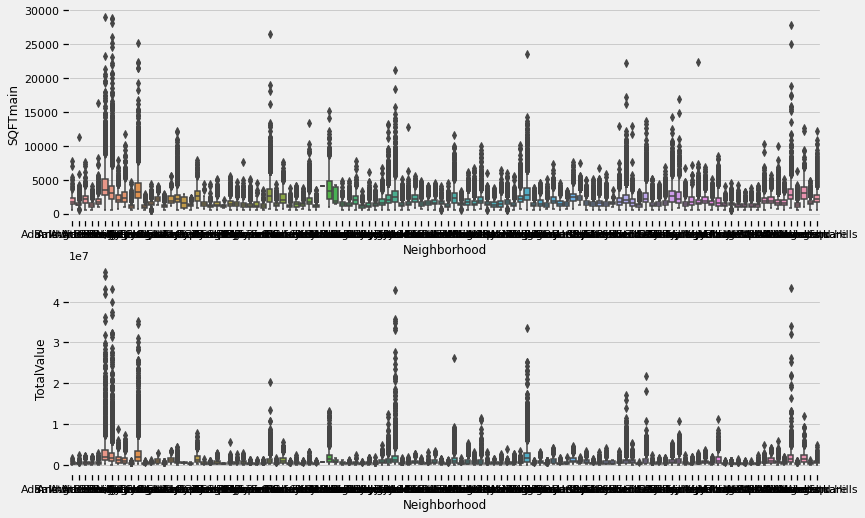

In [18]:
# Find a feature that can help distinguish between richer and "poorer" neighborhoods
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

sns.boxplot(x='Neighborhood', y='SQFTmain', data=train.sort_values('Neighborhood'), ax=axs[0])
sns.boxplot(x='Neighborhood', y='TotalValue', data=train.sort_values('Neighborhood'), ax=axs[1])
plt.show

In [19]:
train[['Neighborhood', 'SQFTmain']].groupby('Neighborhood').median().sort_values(by = 'SQFTmain', ascending = False).iloc[0:5]

,SQFTmain
Neighborhood,
Griffith Park,4092.0
Bel-Air,3504.0
Hancock Park,3347.0
Brentwood,3133.0
Windsor Square,3078.5


It may be considered a data leakage to use TotalValue to find rich and poor neighborhoods, since TotalValue is the target. Use SQFTmain as a work around.

In [20]:
def find_rich_neighborhoods(data, n = 3000, metric=np.median):
    """
    Find wealthy neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a rich neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] > n].index.to_list()
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train)

# Print rich neighborhoods
print('The rich neighborhoods are: {}'.format(rich_neighborhoods))

The rich neighborhoods are: ['Bel-Air', 'Brentwood', 'Griffith Park', 'Hancock Park', 'Windsor Square']


In [21]:
def find_poor_neighborhoods(data, n = 1150, metric=np.median):
    """
    Find poor neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a poor neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] < n].index.to_list()
    
    return neighborhoods

# Find poor neighborhoods
poor_neighborhoods = find_poor_neighborhoods(train)

# Print poor neighborhoods
print('The poor neighborhoods are: {}'.format(poor_neighborhoods))

The poor neighborhoods are: ['Boyle Heights', 'Broadway-Manchester', 'Central-Alameda', 'Cypress Park', 'Downtown', 'Elysian Valley', 'Florence', 'Green Meadows', 'Harvard Park', 'Lincoln Heights', 'Vermont-Slauson', 'Watts']


In [22]:
def add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood'
      rich_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
      poor_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as poor
    Output:
      data frame identical to the input with the addition of two binary
      in_rich_neighborhood and in_poor_neighborhood columns
    """
    data_copy = data.copy()
    
    # Write your code here.
    data_copy['in_rich_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(rich_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    data_copy['in_poor_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(poor_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    return data_copy

# Add 'in_rich_neighborhood' feature
training_data = add_in_neighborhoods(training_data, rich_neighborhoods, poor_neighborhoods)

# View DataFrame
training_data.head()

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,ShapeSTLen,geometry,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,in_rich_neighborhood,in_poor_neighborhood
0,6075031037,2102.0,4,3,163994.0,2004,291407.0,1991,1999,465,...,330.491766,"POLYGON ((-118.28088 33.93555, -118.28086 33.9...",0,0,0,1928.0,1938.0,1158.5,0,0
1,6088016025,1600.0,3,1,183743.0,2001,229671.0,1917,1925,7,...,364.470337,"POLYGON ((-118.28436 33.92625, -118.28453 33.9...",0,0,0,1928.0,1938.0,1158.5,0,0
2,6038006043,777.0,2,1,350263.0,2005,437822.0,1947,1947,212,...,350.320482,"POLYGON ((-118.28418 33.95691, -118.28426 33.9...",0,0,0,1928.0,1938.0,1158.5,0,0
3,6038014048,1458.0,4,2,383370.0,2019,479212.0,1911,1929,212,...,369.450625,"POLYGON ((-118.28758 33.95447, -118.28806 33.9...",0,0,0,1928.0,1938.0,1158.5,0,0
4,6054027027,1162.0,3,2,958831.0,2020,1362975.0,1938,1938,212,...,370.030644,"POLYGON ((-118.28626 33.94832, -118.28641 33.9...",0,0,0,1928.0,1938.0,1158.5,0,0


In [35]:
def rank_rich_neighborhoods(data, metric=np.median):
    featuredata = data.copy() 
    featuredata['RankRich'] = 0
    neighborhoodrank = featuredata.groupby('Neighborhood')['TotalValue'].agg(np.mean).sort_values(ascending=False).to_frame()
    neighborhoodrank['Rank'] = np.arange(neighborhoodrank.shape[0])+1
    neighborhoodrank = neighborhoodrank.reset_index()
    neighborhoodrank
    for i in list(range(len(neighborhoodrank['Neighborhood']))):
        a = featuredata['Neighborhood'].str.lower().str.contains(neighborhoodrank['Neighborhood'][i].lower())
        featuredata.loc[a,['RankRich']] = featuredata.loc[a,['RankRich']]+neighborhoodrank['Rank'][i]    
    return featuredata

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,...,Cluster,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,RankRich
549190,6075031037,2102.0,4,3,163994.0,2004,291407.0,1991,1999,0100,...,9135,90061,1574,1328.401572,2438.546134,Vermont Vista,4582.611328,330.491766,"POLYGON ((-118.28088 33.93555, -118.28086 33.9...",106
71546,2217011066,1468.0,3,2,520800.0,2021,651000.0,1930,1955,0100,...,3139,91405,4045,2278.987082,22582.971949,Van Nuys,9719.463867,413.992977,"POLYGON ((-118.44382 34.19576, -118.44382 34.1...",63
378098,5023024024,754.0,2,1,39419.0,1982,76860.0,1922,1923,0100,...,9181,90008,4007,678.685043,4624.928835,Leimert Park,5195.177734,339.760657,"POLYGON ((-118.32046 34.01018, -118.32089 34.0...",76
102429,2305018007,1269.0,3,2,212739.0,2003,354561.0,1955,1955,0100,...,3130,91605,2127,2102.351378,18939.640434,Sun Valley,5951.470703,313.539365,"POLYGON ((-118.40909 34.21286, -118.40927 34.2...",86
463833,5510018031,2039.0,3,3,146570.0,1981,254724.0,1928,1929,0100,...,9166,90048,4736,559.808250,14914.832433,Beverly Grove,6199.919922,347.997417,"POLYGON ((-118.36231 34.06660, -118.36236 34.0...",10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176284,2556012005,1344.0,3,2,157438.0,2001,320162.0,1992,1992,0100,...,3177,91040,2517,1939.235008,41445.876985,Sunland,4194.666992,339.677067,"POLYGON ((-118.30318 34.26463, -118.30318 34.2...",65
630487,7559033009,1236.0,2,2,569317.0,2018,711646.0,1955,1955,0101,...,14183,90732,3422,1308.163573,38311.533601,San Pedro,6467.133789,335.582498,"POLYGON ((-118.31392 33.73820, -118.31411 33.7...",58
121887,2377019004,4785.0,5,5,535151.0,1999,1375902.0,1998,1998,0100,...,3175,91604,4165,2937.659542,8241.044191,Studio City,11202.065430,460.089356,"POLYGON ((-118.38863 34.13299, -118.38840 34.1...",17
622799,7469016003,1700.0,3,2,105655.0,1979,196660.0,1960,1960,0100,...,14190,90731,6114,2284.787464,38028.566926,San Pedro,6835.746094,373.404110,"POLYGON ((-118.30099 33.71558, -118.30105 33.7...",58


In [36]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Combine all pipelines to create processed data."""
    # One-hot-encode PropertyUseCode feature
    data = ohe_pusecode(data)
    
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Add in the rich and poor neighborhoods
    data = add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods)
    data = rank_rich_neighborhoods(data)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SQFTmain', 
                          'Bedrooms', 
                          'Bathrooms',
                          'LandBaseYear',
                          'TotalValue',
                          'YearBuilt',
                          'EffectiveYearBuilt',
                          'BusBenchClosestDist',
                          'ShapeSTAre',
                          'ShapeSTLen',
                          'in_rich_neighborhood',
                          'in_poor_neighborhood',
                          'YearBuilt_median',
                          'EffectiveYearBuilt_median',
                          'SQFTmain_median',
                          'PropertyUseCode_0101',
                          'PropertyUseCode_0103',
                          'PropertyUseCode_0104',
                          'RankRich')
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

    Copy of all features considered for use:
    
    data = select_columns(data, 
                          'SQFTmain', 
                          'Bedrooms', 
                          'Bathrooms',
                          'LandBaseYear',
                          'TotalValue',
                          'YearBuilt',
                          'EffectiveYearBuilt',
                          'BusBenchClosestDist',
                          'ShapeSTAre',
                          'ShapeSTLen',
                          'in_rich_neighborhood',
                          'in_poor_neighborhood',
                          'YearBuilt_median',
                          'EffectiveYearBuilt_median',
                          'SQFTmain_median',
                          'PropertyUseCode_0101',
                          'PropertyUseCode_0103',
                          'PropertyUseCode_0104')

In [37]:
X_train, y_train = process_data(train)
X_train.head()

,SQFTmain,Bedrooms,Bathrooms,LandBaseYear,YearBuilt,EffectiveYearBuilt,BusBenchClosestDist,ShapeSTAre,ShapeSTLen,in_rich_neighborhood,in_poor_neighborhood,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,RankRich
0,2102.0,4,3,2004,1991,1999,1328.401572,4582.611328,330.491766,0,0,1928.0,1938.0,1158.5,0,0,0,106
1,1600.0,3,1,2001,1917,1925,690.683136,8109.527344,364.470337,0,0,1928.0,1938.0,1158.5,0,0,0,106
2,777.0,2,1,2005,1947,1947,528.511095,5406.794922,350.320482,0,0,1928.0,1938.0,1158.5,0,0,0,106
3,1458.0,4,2,2019,1911,1929,1682.857382,5791.071289,369.450625,0,0,1928.0,1938.0,1158.5,0,0,0,106
4,1162.0,3,2,2020,1938,1938,1162.802096,6300.652344,370.030644,0,0,1928.0,1938.0,1158.5,0,0,0,106


## Create the Linear Regression Model

Create a cross-validation function returning the root mse from all splits

In [38]:
def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)   # Split the data into 5 parts
    rmse_values = []                # Initialize the list of rmse values, to be populated
    
    # Iterature thought cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        
        # Fit model
        model.fit(X.iloc[train_index], y.iloc[train_index])   # Take four parts as the training set, iterated through all possibilities
        y_predicted = model.predict(X.iloc[val_index])        # Take one part as the validation set
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))   # Append to empty list per iteration to populate the rmse values list
        
    return rmse_values

In [39]:
cv_scores = cross_validate_rmse(LinearRegression(), X_train, y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean home price: ${}'.format(np.mean(data['TotalValue'])))

Cross-validation RMSE scores: [865250.6493719756, 394013.673129171, 871407.0360878255, 720980.9479333785, 524216.48175259726]
Cross-validation RMSE scores mean: $675173.7576549896
Cross-validation RMSE scores std: $188983.65817653478
Mean home price: $669181.324128353


In [40]:
X_val, y_val = process_data(val)
cv_scores = cross_validate_rmse(LinearRegression(), X_val, y_val)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [419769.49839566916, 684644.2583144649, 488728.27887595893, 1142444.6740266995, 659511.8721385204]
Cross-validation RMSE scores mean: $679019.7163502625
Cross-validation RMSE scores std: $252426.77732009537


In [41]:
X_test, y_test = process_data(test)
cv_scores = cross_validate_rmse(LinearRegression(), X_test, y_test)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [512771.0722525207, 605538.8390846348, 511296.30775105854, 1026741.3424399018, 809374.6500856502]
Cross-validation RMSE scores mean: $693144.4423227531
Cross-validation RMSE scores std: $199034.86697600991
